# Conshohocken Insurance Company Case Study

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#da">Descriptive Data Analysis</a></li>
<li><a href="#logit">Logistic Regression Models</a></li>   
<li><a href="#conclusion">Conclusions and Next Steps</a></li>
</ul>

<a id='intro'></a>
## Introduction

In the **Introduction** I will do the following:

1)	Define the purpose of the analysis and provide context for the coming sections.

2)	Load the necessary Python packages to do the analysis.

3)	Show the data dictionary for reference

4)	Load the dataset to be analyzed.

#### Purpose and Context
In this notebook, I will wrangle and explore the data for potential rules CIC could implement. This Jupyter Notebook will be paired with Tableau dashboards to help illustrate how I can answer the prompt posed by this case study.

This analysis will examine questions like:

1) **Is there a certain type of lead that CIC shouldn’t bother purchasing?**

2) **What type of consumers should CIC prioritize trying to get on the phone?**

3) **How do the different variables from CIC and Jornaya affect the purchase outcome?**

4) **What is the ideal combination of fields for a lead who purchases insurance?**

5) **How does the Jornaya data provide value?**

To answer these questions, I perform descriptive analysis on both CIC and Jornaya-provided datasets. To maximize the descriptive analysis, I slice the data into sections and add a column. Please note the data is assumed to be clean.

Secondly, I create logistic regression models to examine what variables may impact the purchase outcome and how they could affect rule creation. 

Lastly, I note potential rules CIC could implement based upon this analysis and transition the analysis to Tableau. 

In [673]:
# Importing the different packages used for this analysis.

#For data analysis manipulation
import pandas as pd
#For data analysis manipulation
import numpy as np
#To visually plot and describe data
import matplotlib.pyplot as plt
#To visually plot and describe data
import seaborn as sns
#To create logistic regression model that will create model informing what are the most important variables.
import statsmodels.api as sm
#To plot visualizations inline with the Jupyter Notebook.
%matplotlib inline

In [674]:
#Set the column width so the full description column will be displayed.
pd.set_option('display.max_colwidth',500)

# Load the data dictionary and print it to define and show fields to help guide data analysis.
df_dictionary = pd.read_csv('data_dictionary.csv')
df_dictionary.head(10)

,Field,Field Type,Description
0,token,Standard,A unique valuable that serves as a recordid
1,provider,Standard,The name of the company CIC purchased the lead from
2,lead_cost,Standard,How much CIC paid for the lead
3,contact,Standard,The 0 or 1 flag indicating whether CIC was able to contact the consumer. A 1 indicates contact was made
4,purchase,Standard,The 0 or 1 flag indicating whether a consumer purchased insurance from CIC. A 1 indicates a purchase was made
5,lead_age,Jornaya Supplemented,"The time, in seconds, between when a consumer submitted an online form to when CIC received the lead"
6,lead_duration,Jornaya Supplemented,The number of seconds a consumer spent completing the online form
7,field_count,Jornaya Supplemented,The number of fields in the online form that the consumer was asked to fill in
8,competitors,Jornaya Supplemented,The number of other insurance companies (i.e. competitors) that were also sent the same lead


In [675]:
# Load the CIC data and print the first five rows to see what the data looks like.
df = pd.read_csv('client_leads_with_outcomes.csv')
df.head()

,token,provider,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors
0,1,C,50,0,0,74,962,10,2
1,2,C,50,0,0,47,617,9,3
2,3,A,75,0,0,7,94,14,1
3,4,C,75,0,0,29,104,15,1
4,5,D,75,0,0,27,82,9,1


<a id='da'></a>
## Descriptive Data Analysis

In this section, I perform descriptive analysis on both CIC and Jornaya-provided datasets. To maximize the descriptive analysis, I slice the data into sections and add a column. Please note the data is assumed to be clean. Please note I will periodically add my observations at different points in the analysis and there are comments in the code describing what each block is doing.

#### Initial Descriptive Analysis Observations

* The dataset has 9 columns and 560 rows.
* Every data column is numeric except for provider.
* 16% of all observations responded to contact and 5% purchased insurance from CIC. See the df.describe() command for more details on the numeric data.
* competitors and lead_cost are limited to four unique responses.
* None of the data is purely normally distributed.
* There are three outcomes: (1) A lead was successfully contacted and purchased insurance. (2) A lead was successfully contacted and did not purchase insurance. (3) A lead was not contacted and did not purchase insurance.

In [676]:
# Examine the total rows and columns in the dataset.
df.shape

(560, 9)

In [677]:
# Examine the the data to see if it is cleaned data with no gaps and what data types are present.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 9 columns):
token            560 non-null int64
provider         560 non-null object
lead_cost        560 non-null int64
contact          560 non-null int64
purchase         560 non-null int64
lead_age         560 non-null int64
lead_duration    560 non-null int64
field_count      560 non-null int64
competitors      560 non-null int64
dtypes: int64(8), object(1)
memory usage: 39.5+ KB


In [678]:
# Describe the data to see how it breaks down and what the values of the continuous columns are.
df.describe()

,token,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors
count,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000,560.000000
mean,280.500000,53.973214,0.164286,0.051786,31.996429,826.182143,11.869643,0.562500
std,161.802349,24.772113,0.370866,0.221792,40.007423,861.699817,6.732492,0.856223
min,1.000000,25.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,140.750000,25.000000,0.000000,0.000000,3.000000,112.750000,6.000000,0.000000
50%,280.500000,50.000000,0.000000,0.000000,27.000000,681.000000,12.000000,0.000000
75%,420.250000,75.000000,0.000000,0.000000,50.000000,956.250000,18.000000,1.000000
max,560.000000,100.000000,1.000000,1.000000,466.000000,3409.000000,23.000000,3.000000


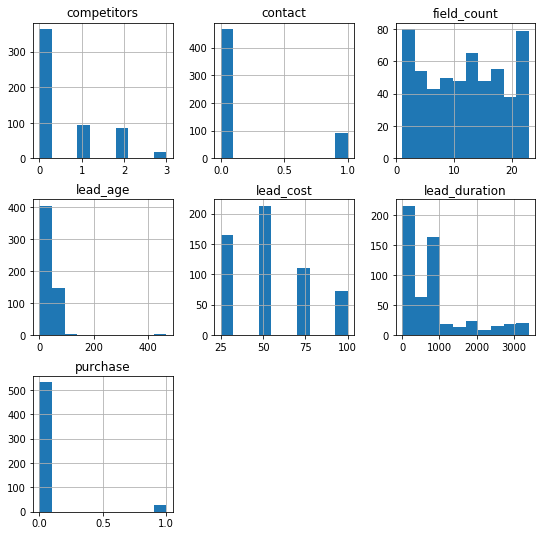

In [679]:
#Examine the histograms of the data to see how it is distributed.
df.drop(['token'],axis=1).hist(figsize=(9,9));

In [680]:
#Count how many rows of data are in each lead_cost category.
df['lead_cost'].value_counts()

50     213
25     165
75     110
100     72
Name: lead_cost, dtype: int64

In [681]:
#Count how many rows of data are in each provider category.
df['provider'].value_counts()

C    233
B    123
D    112
A     92
Name: provider, dtype: int64

In [682]:
#Count how many rows of data were successfully contacted.
df['contact'].value_counts()

0    468
1     92
Name: contact, dtype: int64

In [683]:
#Count how many rows of data were purchased insurance.
df['purchase'].value_counts()

0    531
1     29
Name: purchase, dtype: int64

In [684]:
#Create the function that will add a purchase_and_contact_flag column to the dataset. This is to distinguish between
#who purchased insurance, who was contacted and did not purchase insurance, and who didn't respond to contact and didn't
#purchase insurance.
def contact_purchase_flag(row):
    if row['purchase'] == 1  :
        return 'Contact and Purchase'
    elif row['contact'] == 0 :
        return 'No Purchase or Contact'
    else:
      return 'Contact and No Purchase'

In [685]:
#Apply the function to df to create the new column.
df['purchase_and_contact_flag'] = df.apply(lambda row: contact_purchase_flag(row), axis=1)

In [686]:
#Check to ensure the column was correctly implemented.
df.head()

,token,provider,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors,purchase_and_contact_flag
0,1,C,50,0,0,74,962,10,2,No Purchase or Contact
1,2,C,50,0,0,47,617,9,3,No Purchase or Contact
2,3,A,75,0,0,7,94,14,1,No Purchase or Contact
3,4,C,75,0,0,29,104,15,1,No Purchase or Contact
4,5,D,75,0,0,27,82,9,1,No Purchase or Contact


#### Data Slicing Observations
In the below section, I separate the dataset into three different datasets based on the outcomes in the purchase and contact fields. I separate the data into df0 (no purchase or contact dataset), df1 (contact and purchase dataset), and df2 (contact and no purchase dataset). My other comments are listed in the bullets:

* There is not a significant difference in average field_count between the three datasets.
* The leads in the datasets where contact = 1 or purchase = 1 cost over $19 more on average.
* The leads that purchase have a shorter lead_age by about 10 seconds vs. the other two groups.
* The leads in the datasets where contact = 1 or purchase = 1 have less competitors by about .4 on average.
* The leads that purchase have an average lead_duration (~487) in between the leads that are contacted successfully (~173) and those that are not (~934). The standard deviation is very high except for the leads that are just contacted successfully.

In [687]:
#Creating the df for the leads who were not contacted and did not purchase insurance.
df0 = df[(df['contact'] == 0) & (df['purchase'] == 0)]
df0.head()

,token,provider,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors,purchase_and_contact_flag
0,1,C,50,0,0,74,962,10,2,No Purchase or Contact
1,2,C,50,0,0,47,617,9,3,No Purchase or Contact
2,3,A,75,0,0,7,94,14,1,No Purchase or Contact
3,4,C,75,0,0,29,104,15,1,No Purchase or Contact
4,5,D,75,0,0,27,82,9,1,No Purchase or Contact


In [688]:
#Describing the data for the leads who were not contacted and did not purchase insurance.
df0.describe()

,token,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors
count,468.000000,468.000000,468.0,468.0,468.000000,468.000000,468.000000,468.000000
mean,277.252137,50.534188,0.0,0.0,32.192308,934.997863,11.997863,0.621795
std,162.979106,22.898456,0.0,0.0,25.366044,893.735094,6.763835,0.887768
min,1.000000,25.000000,0.0,0.0,1.000000,0.000000,1.000000,0.000000
25%,130.750000,25.000000,0.0,0.0,6.000000,111.750000,6.000000,0.000000
50%,278.500000,50.000000,0.0,0.0,31.000000,765.500000,12.000000,0.000000
75%,418.250000,75.000000,0.0,0.0,53.000000,1004.250000,18.000000,1.000000
max,560.000000,100.000000,0.0,0.0,80.000000,3409.000000,23.000000,3.000000


In [689]:
#Creating the df for the leads who were successfully contacted and purchased insurance.
df1 = df[(df['contact'] == 1) & (df['purchase'] == 1)]
df1.head()

,token,provider,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors,purchase_and_contact_flag
35,36,A,100,1,1,1,537,22,0,Contact and Purchase
52,53,C,100,1,1,26,515,13,0,Contact and Purchase
65,66,C,75,1,1,1,431,22,1,Contact and Purchase
80,81,C,25,1,1,17,649,10,0,Contact and Purchase
115,116,C,100,1,1,1,206,8,0,Contact and Purchase


In [690]:
#Describing the data for the leads who were successfully contacted and did purchase insurance.
df1.describe()

,token,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors
count,29.00000,29.000000,29.0,29.0,29.000000,29.000000,29.000000,29.000000
mean,263.62069,69.827586,1.0,1.0,21.344828,487.793103,10.827586,0.206897
std,143.16160,29.413395,0.0,0.0,49.857852,461.416405,6.840368,0.491304
min,36.00000,25.000000,1.0,1.0,1.000000,25.000000,1.000000,0.000000
25%,158.00000,50.000000,1.0,1.0,1.000000,212.000000,4.000000,0.000000
50%,255.00000,75.000000,1.0,1.0,7.000000,434.000000,11.000000,0.000000
75%,377.00000,100.000000,1.0,1.0,17.000000,637.000000,16.000000,0.000000
max,556.00000,100.000000,1.0,1.0,245.000000,2556.000000,23.000000,2.000000


In [691]:
#Creating the df for the leads who were successfully contacted and did not purchase insurance.
df2 = df[(df['contact'] == 1) & (df['purchase'] == 0)]
df2.head()

,token,provider,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors,purchase_and_contact_flag
7,8,C,50,1,0,4,64,9,0,Contact and No Purchase
8,9,A,100,1,0,1,162,5,0,Contact and No Purchase
38,39,A,100,1,0,54,286,11,0,Contact and No Purchase
57,58,C,75,1,0,1,213,10,0,Contact and No Purchase
78,79,C,50,1,0,1,91,23,0,Contact and No Purchase


In [692]:
#Describing the data for the leads who were successfully contacted and did not purchase insurance.
df2.describe()

,token,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors
count,63.000000,63.000000,63.0,63.0,63.000000,63.000000,63.000000,63.000000
mean,312.396825,72.222222,1.0,0.0,35.444444,173.603175,11.396825,0.285714
std,159.581867,25.444084,0.0,0.0,91.632819,80.080310,6.487058,0.633184
min,8.000000,25.000000,1.0,0.0,1.000000,56.000000,1.000000,0.000000
25%,176.500000,50.000000,1.0,0.0,1.000000,102.000000,5.500000,0.000000
50%,328.000000,75.000000,1.0,0.0,5.000000,163.000000,10.000000,0.000000
75%,466.500000,100.000000,1.0,0.0,31.000000,221.500000,17.000000,0.000000
max,554.000000,100.000000,1.0,0.0,466.000000,496.000000,23.000000,2.000000


In [693]:
#Check to ensure no leads that weren't contacted successfully purchased insurance from CIC.
df3 = df[(df['contact'] == 0) & (df['purchase'] == 1)]
df3.head()

,token,provider,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors,purchase_and_contact_flag


In [694]:
#Check to ensure the df row counts match with the original df.
(df3['token'].count() + df2['token'].count() + df1['token'].count() + df0['token'].count()) == df['token'].count()

True

#### Categorical Data Visualization Observations
In the below section, I create a function to visualize my categorical data. My comments from the created visualizations are listed below:

* Provider A is the best for leads that convert to purchases while Provider B is the worst.
* 100 dollar leads are the best at converting into purchases while 50 dollar leads are the worst at converting into purchases.
* No leads that had 3 competitors converted into purchases while leads that had 0 competitors converted most often.
* lead_cost and competitors are analyzed in this section and the continous data visualization section, given their categories are numerical.

In [695]:
def grouped_bar_graph(N,df_1,df_2,df_3,title,labels_df,ylimit):
    
    #To create the bar chart that shows the different categories of data
    #Defining how many different groups there will be in the bar chart
    
    ind = np.arange(N)  # the x locations for the groups
    width = 0.25       # the width of the bars
    fig, ax = plt.subplots()
    
    #Defining the data that shows the number of leads who did not purchase or respond to contact
    no_purchase_or_contact_values = df_1
    rects1 = ax.bar(ind, no_purchase_or_contact_values, width, color='black')
    
    #Defining the data that shows the number of leads who responded to contact, but did not purchase
    contact_values = df_2
    rects2 = ax.bar(ind + width, contact_values, width, color='silver')
    
    #Defining the data that shows the number of leads who responded to contact and purchased
    purchase_values = df_3
    rects3 = ax.bar(ind + width*2, purchase_values, width, color='gold')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Leads')
    ax.set_title(title)
    ax.set_xticks(ind + width)
    ax.set_xticklabels(labels_df)
    
    #Creating the axis legend
    ax.legend((rects1[0], rects2[0], rects3[0]), ('No Purchase or Contact', 'Contact and No Purchase','Contact and Purchase'))
    
    def autolabel(rects):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
    
    #Running the autolabel functions defined above to create labels for the bars
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.ylim(0, ylimit)
    plt.show()   # show the chart

In [696]:
#Checking the counts by provider of how many leads were not contacted and did not purchase.
df0.groupby(['provider']).count()

,token,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors,purchase_and_contact_flag
provider,,,,,,,,,
A,67,67,67,67,67,67,67,67,67
B,110,110,110,110,110,110,110,110,110
C,205,205,205,205,205,205,205,205,205
D,86,86,86,86,86,86,86,86,86


In [697]:
#Checking the counts by provider of how many leads were contacted and purchased.
df1.groupby(['provider']).count()

,token,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors,purchase_and_contact_flag
provider,,,,,,,,,
A,9,9,9,9,9,9,9,9,9
B,2,2,2,2,2,2,2,2,2
C,10,10,10,10,10,10,10,10,10
D,8,8,8,8,8,8,8,8,8


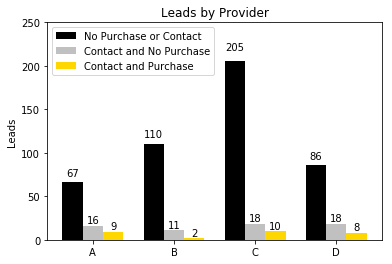

In [698]:
#Create the categorical bar chart for provider.
input_df1 = df0.groupby(['provider']).count()['token']
input_df2 = df2.groupby(['provider']).count()['token']
input_df3 = df1.groupby(['provider']).count()['token']
input_title = 'Leads by Provider'
input_labels = ['A','B','C','D']
grouped_bar_graph(4,input_df1,input_df2,input_df3,input_title,input_labels,250)

In [699]:
#Checking the counts by lead_cost of how many leads were contacted and purchased.
df1.groupby(['lead_cost']).count()

,token,provider,contact,purchase,lead_age,lead_duration,field_count,competitors,purchase_and_contact_flag
lead_cost,,,,,,,,,
25,7,7,7,7,7,7,7,7,7
50,2,2,2,2,2,2,2,2,2
75,10,10,10,10,10,10,10,10,10
100,10,10,10,10,10,10,10,10,10


In [700]:
#Checking the counts by lead_cost of how many leads were not contacted and did not purchase.
df0.groupby(['lead_cost']).count()

,token,provider,contact,purchase,lead_age,lead_duration,field_count,competitors,purchase_and_contact_flag
lead_cost,,,,,,,,,
25,151,151,151,151,151,151,151,151,151
50,196,196,196,196,196,196,196,196,196
75,81,81,81,81,81,81,81,81,81
100,40,40,40,40,40,40,40,40,40


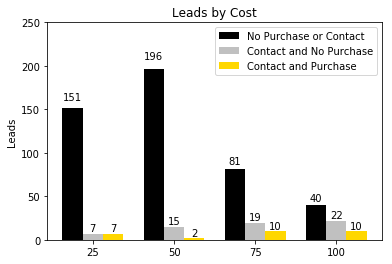

In [701]:
#Create the categorical bar chart for lead_cost.
input_df1 = df0.groupby(['lead_cost']).count()['token']
input_df2 = df2.groupby(['lead_cost']).count()['token']
input_df3 = df1.groupby(['lead_cost']).count()['token']
input_title = 'Leads by Cost'
input_labels = ['25','50','75','100']
grouped_bar_graph(4,input_df1,input_df2,input_df3,input_title,input_labels,250)

In [702]:
#Checking the counts by lead_cost of how many leads were contacted and did not purchase.
df2.groupby(['competitors']).count()

,token,provider,lead_cost,contact,purchase,lead_age,lead_duration,field_count,purchase_and_contact_flag
competitors,,,,,,,,,
0,51,51,51,51,51,51,51,51,51
1,6,6,6,6,6,6,6,6,6
2,6,6,6,6,6,6,6,6,6


In [703]:
#Creating a row with 0 listed in it for everything since df2.groupby(['competitors']).count() does not have a '3'
#for competitors. If this was inputted into the function, the function would fail since the datasets being put into it do
#not match in their shape.

append_row = pd.DataFrame({"token":[0],
                           "provider":[0],
                           "lead_cost":[0],
                           "contact":[0],
                           "purchase":[0],
                           "lead_age":[0],
                           "purchase_and_contact_flag":[0],
                           "lead_duration":[0],
                           "field_count":[0]})

as_list = append_row.index.tolist()
idx = as_list.index(0)
as_list[idx] = 3
append_row.index = as_list

append_row.index.name = 'competitors'

In [704]:
#Add in the zeroed out '3' row for df2 and checking to ensure it works
df2.groupby(['competitors']).count().append(append_row)

,contact,field_count,lead_age,lead_cost,lead_duration,provider,purchase,purchase_and_contact_flag,token
competitors,,,,,,,,,
0,51,51,51,51,51,51,51,51,51
1,6,6,6,6,6,6,6,6,6
2,6,6,6,6,6,6,6,6,6
3,0,0,0,0,0,0,0,0,0


In [705]:
#The same zeroed out '3' row will need to be added for df1.
df1.groupby(['competitors']).count()

,token,provider,lead_cost,contact,purchase,lead_age,lead_duration,field_count,purchase_and_contact_flag
competitors,,,,,,,,,
0,24,24,24,24,24,24,24,24,24
1,4,4,4,4,4,4,4,4,4
2,1,1,1,1,1,1,1,1,1


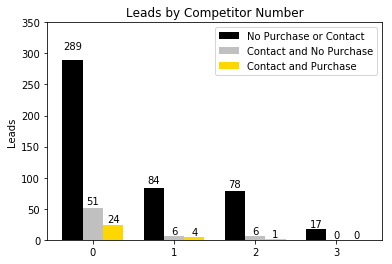

In [706]:
#Create the categorical bar chart for competitor numbers.
input_df1 = df0.groupby(['competitors']).count()['token']
#append_row dataframe defined above is needed here to match the data shapes
input_df2 = df2.groupby(['competitors']).count().append(append_row)['token']
#append_row dataframe defined above is needed here to match the data shapes
input_df3 = df1.groupby(['competitors']).count().append(append_row)['token']
input_title = 'Leads by Competitor Number'
input_labels = ['0','1','2','3']
grouped_bar_graph(4,input_df1,input_df2,input_df3,input_title,input_labels,350)

#### Continous Data Visualization Observations
In the below section, I create a loop to visualize my continous data. My comments from the created visualizations are listed below:

* This visually confirms what I listed out in my observations in the first <a href="#da">Descriptive Data Analysis</a> section.

In [707]:
#Create the grouped df that will be looped through and referenced to create the horizontal bar charts below
df_grouped = df.groupby(['purchase_and_contact_flag']).mean() #Utilizing mean for the continuous data
df_grouped.drop(['contact', 'purchase', 'token'], axis=1, inplace = True) #dropping the categorical data from the df
df_grouped.reset_index(level=0, inplace=True) #resetting the index so purchase_and_contact_flag will not be it
df_grouped.head()

,purchase_and_contact_flag,lead_cost,lead_age,lead_duration,field_count,competitors
0,Contact and No Purchase,72.222222,35.444444,173.603175,11.396825,0.285714
1,Contact and Purchase,69.827586,21.344828,487.793103,10.827586,0.206897
2,No Purchase or Contact,50.534188,32.192308,934.997863,11.997863,0.621795


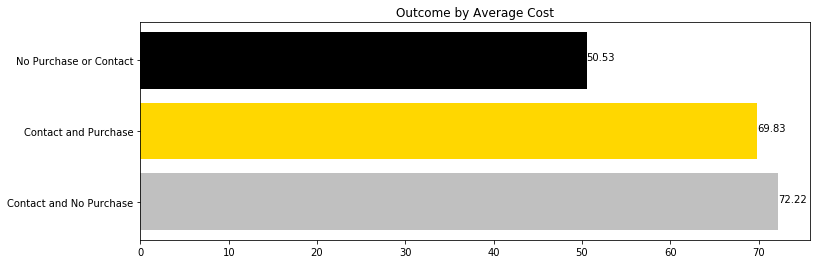

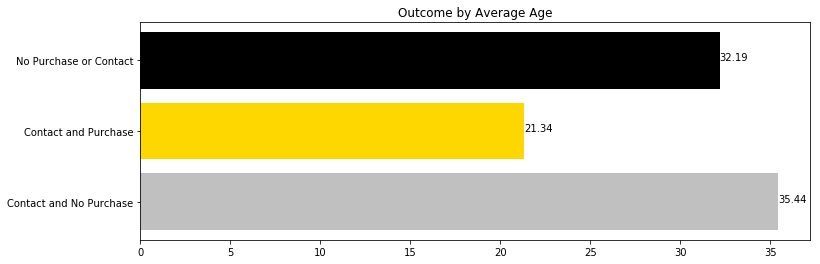

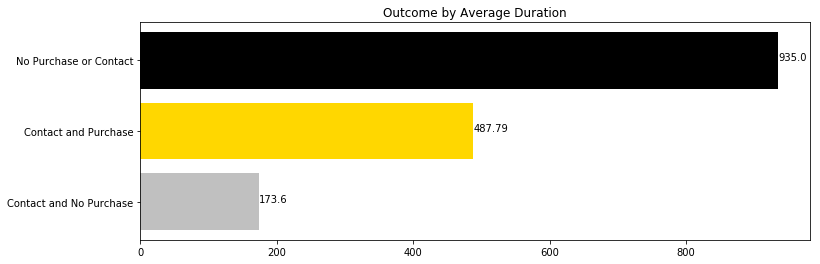

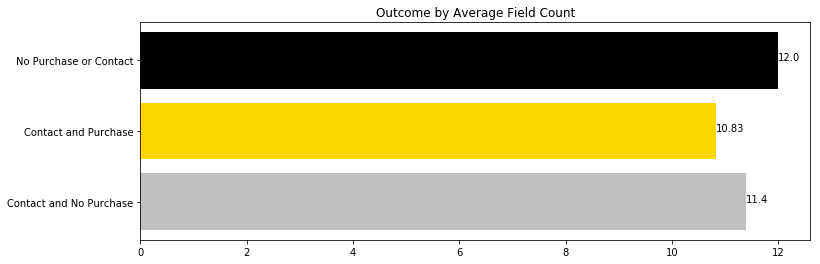

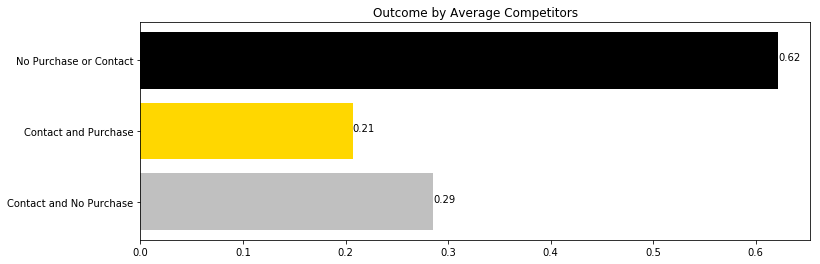

In [708]:
#Setting the data that will be utilized to create the bars as y and the data to categorize it as x
y = [df_grouped['lead_cost'],df_grouped['lead_age'],df_grouped['lead_duration'],df_grouped['field_count'],df_grouped['competitors']]
x = [df_grouped['purchase_and_contact_flag'],df_grouped['purchase_and_contact_flag'],df_grouped['purchase_and_contact_flag'],df_grouped['purchase_and_contact_flag'],df_grouped['purchase_and_contact_flag']]
#Listing the different titles for the charts and the color scheme to be used on all of them
titles = ['Outcome by Average Cost','Outcome by Average Age','Outcome by Average Duration','Outcome by Average Field Count','Outcome by Average Competitors']
colors = ['silver','gold','black']

#Loop through the number of datasets in x and for each one plot a horizontal bar chart with numerical data from y and
#categorical data from x. Place each title on the graph and color them accordingly. Within each dataset, place the numerical
#data labels at the end of each bar.
for i in range(len(x)):
    plt.figure(figsize=[12,4])
    plt.barh(x[i], y[i], align='center',color=colors)
    plt.title(titles[i])
    for ii in range(len(x[i])):
        plt.text(y[i][ii],x[i][ii], round(y[i][ii],2))

<a id='logit'></a>
## Logistic Regression Models
In this section, I iterate through 4 logistic regression models to examine what variables may impact the purchase outcome and how they could affect rule creation. For logistic regression, we are interpreting the odds ratio. To illustrate, say there are 7 males admitted to a college and 3 males not admitted. On the other hand, 3 females are admitted to the college and 7 are not. The odds ratio would be calulated like **((7/3) / (3/7))** with the numerator for males and the denominator for females. For more info see this website: https://stats.idre.ucla.edu/stata/faq/how-do-i-interpret-odds-ratios-in-logistic-regression/

I list my observations below:

#### Models Observations

* I transformed my provider column into multiple binary variables in order to utilize it properly for this analysis.
* One shortcoming of these models is that I did not turn competitors or lead_cost into binary variables as well. However I did not want to saturate my model with binary variables left them as continous (in reality competitors can be much more numerous than 3 and cost is likely to differentiate beyond four prices).
* The models the suggest the less competitors there are for a lead the more likely CIC is to get them to purchase.
* Model1 suggests that changes up or down lead_duration have little effect on the outcome. This corresponds to the data since the purchasers' lead durations times were in the middle of the dataset.
* Model1 suggests Provider A is the best provider.
* Model1 suggests increases in lead_age and field_count lead to less purchases.
* Model_c1 suggests competitors and lead_cost are the two strongest predictors, though they are not tremendously strong.
* Model_c1 suggest buying more expensive leads lead to more purchase conversions.
* The overall predictive value of the models are not strong (<10%). These models do not suggest anything striking that was not suggested in the descriptive analysis.

In [709]:
#creating dummy variables out of the provider variable to feed it into the model
dummy_ranks = pd.get_dummies(df['provider'])
dummy_ranks.head()

,A,B,C,D
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,1,0
4,0,0,0,1


In [710]:
#join the dummy variables into the dataset
df = df.join(dummy_ranks.loc[:, 'B':])
df.head()

,token,provider,lead_cost,contact,purchase,lead_age,lead_duration,field_count,competitors,purchase_and_contact_flag,B,C,D
0,1,C,50,0,0,74,962,10,2,No Purchase or Contact,0,1,0
1,2,C,50,0,0,47,617,9,3,No Purchase or Contact,0,1,0
2,3,A,75,0,0,7,94,14,1,No Purchase or Contact,0,0,0
3,4,C,75,0,0,29,104,15,1,No Purchase or Contact,0,1,0
4,5,D,75,0,0,27,82,9,1,No Purchase or Contact,0,0,1


In [711]:
#splitting data into independent and dependent variables
#I treat A as our baseline and exclude it from our fit. This is done to prevent multicollinearity, or the dummy variable
#trap caused by including a dummy variable for every single category.
x_cols = ['B','C','D','lead_age','lead_duration','field_count','competitors','lead_cost']
x_vars = df[x_cols]
y_var = df['purchase']
x_vars.head()

,B,C,D,lead_age,lead_duration,field_count,competitors,lead_cost
0,0,1,0,74,962,10,2,50
1,0,1,0,47,617,9,3,50
2,0,0,0,7,94,14,1,75
3,0,1,0,29,104,15,1,75
4,0,0,1,27,82,9,1,75


In [712]:
#Check to ensure the data is the proper type to feed into the model
x_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 8 columns):
B                560 non-null uint8
C                560 non-null uint8
D                560 non-null uint8
lead_age         560 non-null int64
lead_duration    560 non-null int64
field_count      560 non-null int64
competitors      560 non-null int64
lead_cost        560 non-null int64
dtypes: int64(5), uint8(3)
memory usage: 23.6 KB


In [713]:
#Run the first model with no constant
model=sm.Logit(y_var,x_vars)
result=model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.185404
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               purchase   No. Observations:                  560
Model:                          Logit   Df Residuals:                      552
Method:                           MLE   Df Model:                            7
Date:                Tue, 28 May 2019   Pseudo R-squ.:                 0.09000
Time:                        07:05:46   Log-Likelihood:                -103.83
converged:                       True   LL-Null:                       -114.09
                                        LLR p-value:                  0.004521
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
B                -1.9517      0.781     -2.498      0.012      -3.483      -0.421
C                -1.0416      0.440     -2.368      0.018      -1.904      -0.180
D                -0.6862      0.466     -1.472      0.141      -1.600       0.228
lead_age         -0.0158      0.008     -1.861      0.063      -0.032       0.001
lead_duration    -0.0008      0.000     -2.453      0.014      -0.001      -0.000
field_count      -0.0380      0.027     -1.384      0.166      -0.092       0.016
competitors      -1.0783      0.406     -2.655      0.008      -1.874      -0.282
lead_cost        -0.0053      0.005     -1.080      0.280      -0.015       0.004
=================================================================================
"""

In [714]:
#Given the first model's field_count was statistically insignificant, run the second model with no constant while dropping
#the lead_cost field
x_vars1 = x_vars.drop(['lead_cost'],axis=1)
model1=sm.Logit(y_var,x_vars1)
result1=model1.fit()
result1.summary()

Optimization terminated successfully.
         Current function value: 0.186471
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               purchase   No. Observations:                  560
Model:                          Logit   Df Residuals:                      553
Method:                           MLE   Df Model:                            6
Date:                Tue, 28 May 2019   Pseudo R-squ.:                 0.08476
Time:                        07:05:46   Log-Likelihood:                -104.42
converged:                       True   LL-Null:                       -114.09
                                        LLR p-value:                  0.003624
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
B                -1.9464      0.779     -2.499      0.012      -3.473      -0.420
C                -1.1206      0.426     -2.629      0.009      -1.956      -0.285
D                -0.8239      0.445     -1.849      0.064      -1.697       0.049
lead_age         -0.0183      0.008     -2.212      0.027      -0.035      -0.002
lead_duration    -0.0008      0.000     -2.323      0.020      -0.001      -0.000
field_count      -0.0553      0.023     -2.455      0.014      -0.099      -0.011
competitors      -1.1800      0.403     -2.930      0.003      -1.969      -0.391
=================================================================================
"""

In [715]:
#The model had an approximate accuracy of 8.48% (very weak) and had statisticall significant variables at the 10% level.
#Getting the odds ratios.
np.exp(result1.params)

B                0.142789
C                0.326097
D                0.438709
lead_age         0.981871
lead_duration    0.999232
field_count      0.946177
competitors      0.307270
dtype: float64

#### Model1 Interpretation

**All of these interpretations are holding every other variable constant for model1.**
* The odds of a lead from Provider B purchasing is ~.14 times that of Provider A.
* The odds of a lead from Provider B purchasing is ~.32 times that of Provider A.
* The odds of a lead from Provider B purchasing is ~.43 times that of Provider A.
* For  every 1 second increase in lead_age, we expect the odds of purchasing to decrease ~2%.
* For every 1 second increase in lead_duration, we expect a near 0 effect on the odds of purchasing.
* For every 1 field increase the field_count, we expect the odds of purchasing to decrease ~5%.
* For every 1 competitor increase in competitors, we expect the odds of purchasing to decrease ~69%.

In [716]:
#Run the first model with a constant to see if it can improve accuracy
x_vars_c = sm.add_constant(x_vars)
model_c=sm.Logit(y_var,x_vars_c)
result_c=model_c.fit()
result_c.summary()

Optimization terminated successfully.
         Current function value: 0.180684
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               purchase   No. Observations:                  560
Model:                          Logit   Df Residuals:                      551
Method:                           MLE   Df Model:                            8
Date:                Tue, 28 May 2019   Pseudo R-squ.:                  0.1132
Time:                        07:05:46   Log-Likelihood:                -101.18
converged:                       True   LL-Null:                       -114.09
                                        LLR p-value:                  0.001126
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.4241      1.096     -2.211      0.027      -4.573      -0.275
B                -1.0320      0.888     -1.162      0.245      -2.773       0.709
C                -0.3556      0.545     -0.652      0.514      -1.424       0.713
D                -0.0764      0.553     -0.138      0.890      -1.161       1.008
lead_age         -0.0125      0.009     -1.467      0.142      -0.029       0.004
lead_duration    -0.0003      0.000     -0.909      0.363      -0.001       0.000
field_count      -0.0155      0.030     -0.523      0.601      -0.074       0.043
competitors      -0.9274      0.409     -2.268      0.023      -1.729      -0.126
lead_cost         0.0143      0.010      1.401      0.161      -0.006       0.034
=================================================================================
"""

In [717]:
#The fields that are dropped below are all statistically insignificant in the logistic regression model, even after doing
#multiple iterations. Therefore, I drop them all at once in this model.
x_vars_c1 = x_vars_c.drop(['D','field_count','C','lead_duration','B','lead_age'],axis=1)
x_vars_c1 = sm.add_constant(x_vars_c1)
model_c1=sm.Logit(y_var,x_vars_c1)
result_c1=model_c1.fit()
result_c1.summary()

Optimization terminated successfully.
         Current function value: 0.185885
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               purchase   No. Observations:                  560
Model:                          Logit   Df Residuals:                      557
Method:                           MLE   Df Model:                            2
Date:                Tue, 28 May 2019   Pseudo R-squ.:                 0.08764
Time:                        07:05:46   Log-Likelihood:                -104.10
converged:                       True   LL-Null:                       -114.09
                                        LLR p-value:                 4.545e-05
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.0970      0.515     -7.949      0.000      -5.107      -3.087
competitors    -0.9252      0.392     -2.361      0.018      -1.693      -0.157
lead_cost       0.0251      0.007      3.612      0.000       0.011       0.039
===============================================================================
"""

In [718]:
#The model had an approximate accuracy of 8.76% (very weak) and had statisticall significant variables at the 5% level.
#Getting the odds ratios.
np.exp(result_c1.params)

const          0.016622
competitors    0.396434
lead_cost      1.025373
dtype: float64

#### Model_c1 Interpretation

**All of these interpretations are holding every other variable and the intercept constant for model_c1.**

* For every 1 dollar increase in lead_cost, we expect the odds of purchasing to increase ~3%.
* For every 1 competitor increase in competitors, we expect the odds of purchasing to decrease ~60%.

<a id='conclusion'></a>
## Conclusion and Next Steps

#### Conclusion
Concluding the Jupyer Notebook analysis, the results here directly address the questions listed at the top. Without the Jornaya data, it would not have been possible to learn about CIC's leads as well as I did. While CIC could investigate cost, contact conversion, purchase conversion, and providers - the company should strongly consider supplementing their dataset with Jornaya's.

Jornaya's and CIC's dataset suggest some of the following:

1) CIC should not bother purchasing leads that have 3 or more competitors (0 purchase conversions).

2) In fact, the less competitors the better! Leads with 0 competitors are the most successful.

3) CIC may want to prioritize leads that spend a moderate amount of time filling out an online form.

4) CIC may want to prioritize leads that they receive quickly following their online form submission.

5) Getting leads with less field counts may lead to more success, but CIC should prioritize using Jornaya's other data points before this one.

6) Leads that cost more seem to convert to purchases more often.

7) While no Provider is particularly strong, Provider A has provided the most leads that convert to purchases.

#### Next Steps
For the next and final portion of this analysis, I will load this data into Tableau to complete the analysis and prepare it for the presentation.